<a href="https://colab.research.google.com/github/romanlents/McKinsey-Prohack-2020/blob/master/presentation_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#@title
import numpy as np 
import pandas as pd 
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [21]:
#@title
import time

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")

<h1 id="tocheading">Table of Contents</h1>

* [Quick Intro to Time Series](#section-one)
* [Cross-validation of Time Series](#section-two)
* [Application](#section-three)
* [PROHACK International Hackathon from McKinsey](#section-four)
* [Feature Engineering](#section-five)
* [Metric](#section-six)
* [LGBM](#section-seven)
* [Ensemble of 3 model (CatBoost, LGBM, XGBoost](#section-eight)
* [Optimization with SciPy](#section-nine)
* [The End](#section-ten)
* [Neptune AI for Version Control and Experiments](#section-eleven)

<a id="section-one"></a>
# Quick Intro to Time Series Analysis

<h3> <font color='green'> Methods for Time Series Forecasting


**Left-hand side:** Supervised Machine Learning models

**Right-hand side:** Classical Econometrics and Deep Learning models

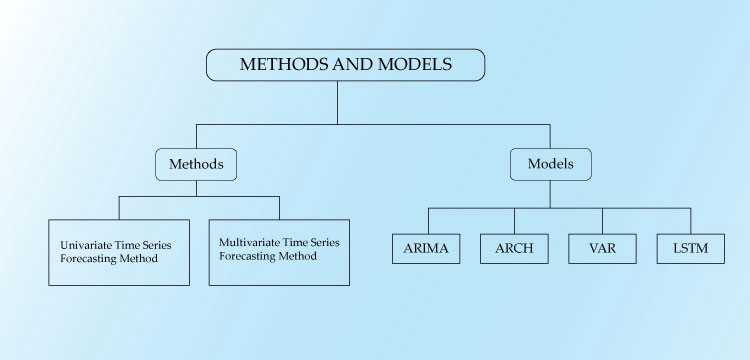

There are three ways to work with Time Series analysis:

* Classical Econometrics methods (e.g. ARMA, ARIMA, SARIMA, Facebook Prophet models etc.)
* Deep Learning (LSTM)
* Supervised Machine Learning

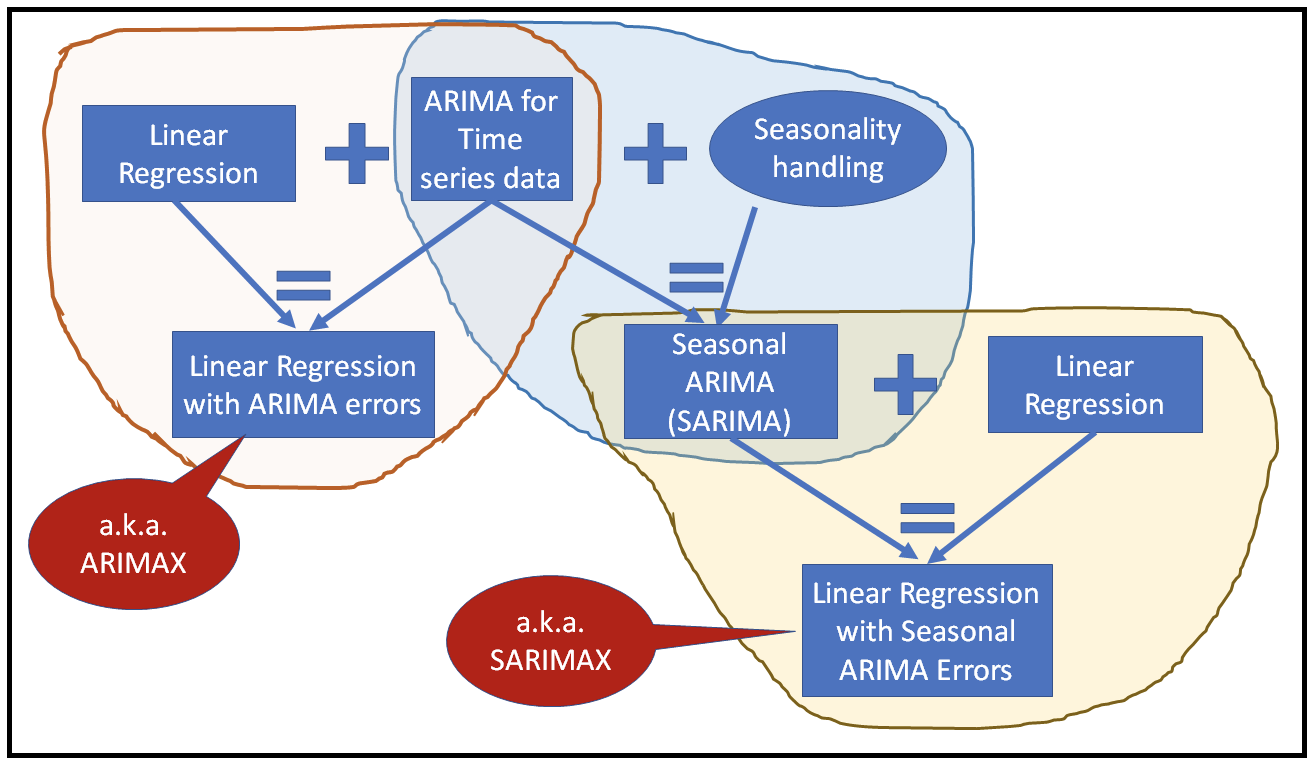

<h3> <font color='green'> Example of Econometrics Approach using ARIMA

**AR(x)** means x lagged error terms are going to be used in the ARIMA model. 

**Integrated** is a degree of differencing to get rid of non-stationarity.

**MA(x)** where x represents previous observations that are used to calculate current observation.

In [22]:
#@title
def parser(x):
  return pd.datetime.strptime('190'+x, '%Y-%m')
 
example = pd.read_csv('/content/drive/My Drive/Colab Notebooks/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

example

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales, dtype: float64

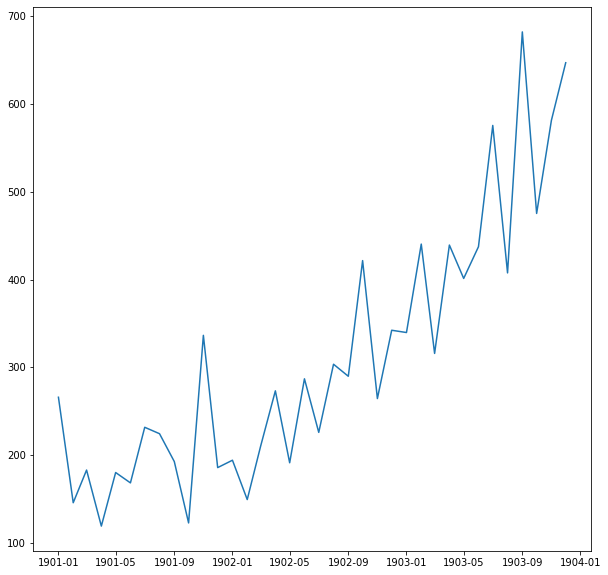

In [23]:
#@title
plt.figure(figsize=(10, 10))
plt.plot(example)
plt.show()

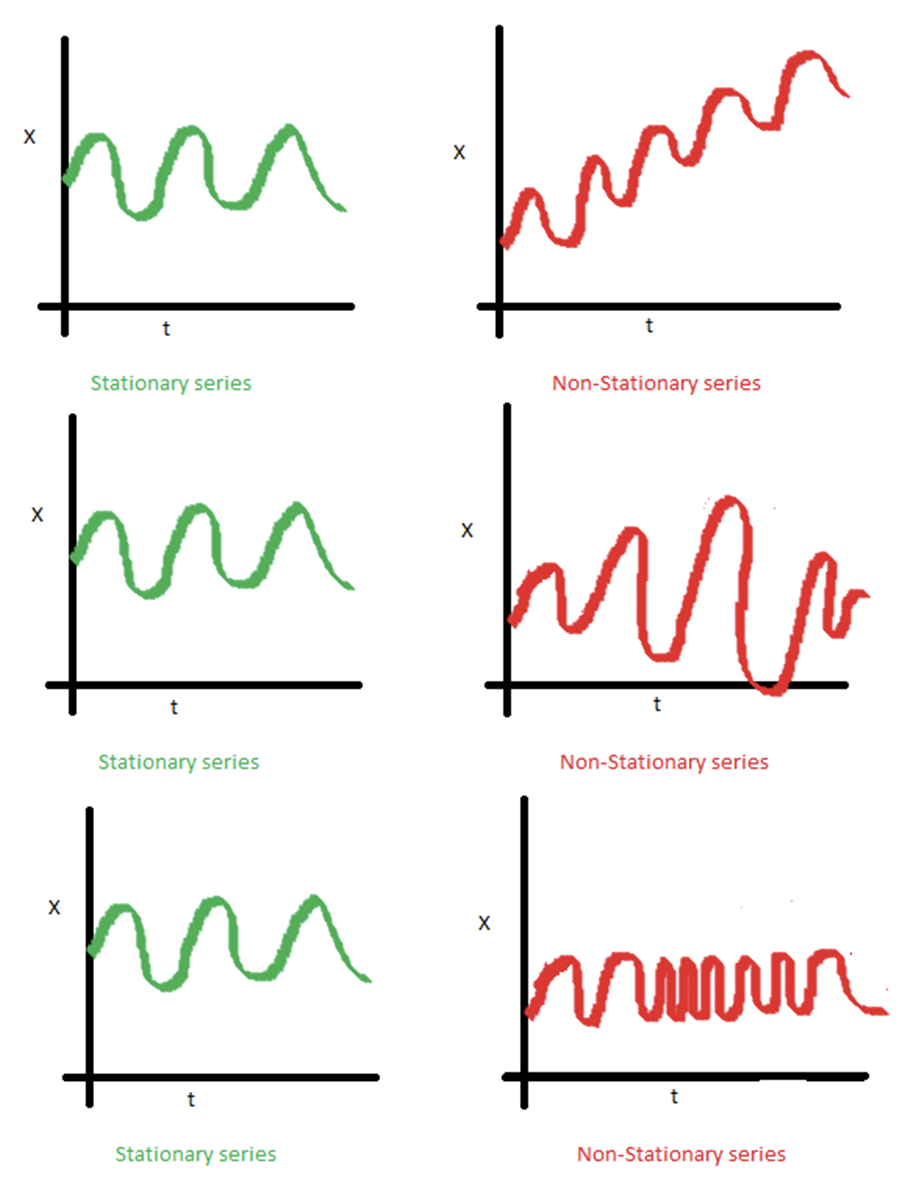

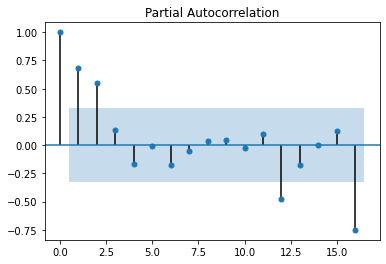

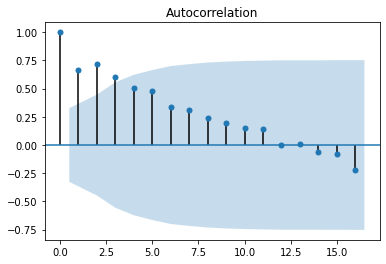

In [24]:
#@title
plot_pacf(example);
plot_acf(example);

In [25]:
#@title
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(example)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.0601420836411797
p-value: 1.0


In [26]:
#@title
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)
X = example.values
diff = difference(X)
diff

0    -120.1
1      37.2
2     -63.8
3      61.0
4     -11.8
5      63.3
6      -7.3
7     -31.7
8     -69.9
9     213.6
10   -150.6
11      8.4
12    -44.8
13     60.6
14     63.2
15    -81.9
16     95.6
17    -61.0
18     77.6
19    -13.7
20    131.7
21   -157.1
22     77.8
23     -2.6
24    100.7
25   -124.5
26    123.4
27    -38.0
28     36.1
29    138.1
30   -167.9
31    274.4
32   -206.7
33    106.0
34     65.6
dtype: float64

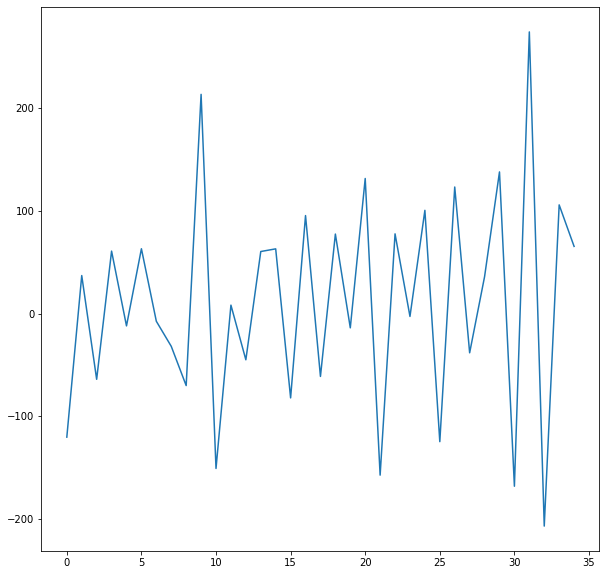

In [27]:
#@title
plt.figure(figsize=(10,10))
plt.plot(diff)
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
#@title
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.249074055553854
p-value: 1.7998574141687034e-10


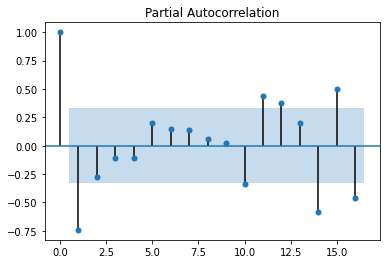

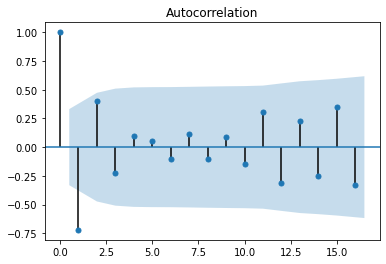

In [29]:
#@title
plot_pacf(diff);
plot_acf(diff);

In [30]:
#@title
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

import math
from itertools import product 


ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=example)
result_df

(p, d, q)         AIC
0   (0, 1, 2)  399.460919
1   (1, 1, 2)  401.262923
2   (0, 1, 3)  401.268640
3   (5, 1, 2)  401.856110
4   (2, 1, 4)  402.571415
..        ...         ...
58  (5, 1, 7)  411.174231
59  (6, 1, 6)  412.353178
60  (0, 1, 1)  413.125234
61  (6, 1, 7)  413.814697
62  (0, 1, 0)  429.228747

[63 rows x 2 columns]

In [31]:
#@title
best_model = SARIMAX(example, seasonal_order=(0,0,0,0), order=(1,1,0)).fit()
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -201.287
Date:                Sun, 01 Nov 2020   AIC                            406.575
Time:                        18:07:05   BIC                            409.686
Sample:                    01-01-1901   HQIC                           407.649
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7142      0.136     -5.259      0.000      -0.980      -0.448
sigma2      5683.4514   1448.557      3.924      0.000    2844.331    8522.572
Ljung-Box (Q):                         nan   Jarque-

In [32]:
#@title
best_model.predict(start = '1904-01-01', end = '1904-01-01')

1904-01-01    600.046377
Freq: MS, dtype: float64

<h3> <font color='green'> Example of Supervised ML Approach

In [41]:
#@title
example = pd.DataFrame(pd.read_csv('/content/drive/My Drive/Colab Notebooks/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser))
df2 = pd.DataFrame([np.NAN], columns = ['Sales'])
example = example.append(df2, ignore_index=True)
example['Sales_lag_1'] = example['Sales'].shift(1)
example['Sales_lag_2'] = example['Sales'].shift(2)
example['Sales_lag_3'] = example['Sales'].shift(3)

example

Sales  Sales_lag_1  Sales_lag_2  Sales_lag_3
0   266.0          NaN          NaN          NaN
1   145.9        266.0          NaN          NaN
2   183.1        145.9        266.0          NaN
3   119.3        183.1        145.9        266.0
4   180.3        119.3        183.1        145.9
5   168.5        180.3        119.3        183.1
6   231.8        168.5        180.3        119.3
7   224.5        231.8        168.5        180.3
8   192.8        224.5        231.8        168.5
9   122.9        192.8        224.5        231.8
10  336.5        122.9        192.8        224.5
11  185.9        336.5        122.9        192.8
12  194.3        185.9        336.5        122.9
13  149.5        194.3        185.9        336.5
14  210.1        149.5        194.3        185.9
15  273.3        210.1        149.5        194.3
16  191.4        273.3        210.1        149.5
17  287.0        191.4        273.3        210.1
18  226.0        287.0        191.4        273.3
19  303.6        226.0        287.0        191.4
20  289.9        303.6        226.0        287.0
21  421.6        289.9        303.6        226.0
22  264.5        421.6        289.9        303.6
23  342.3        264.5        421.6        289.9
24  339.7        342.3        264.5        421.6
25  440.4        339.7        342.3        264.5
26  315.9        440.4        339.7        342.3
27  439.3        315.9        440.4        339.7
28  401.3        439.3        315.9        440.4
29  437.4        401.3        439.3        315.9
30  575.5        437.4        401.3        439.3
31  407.6        575.5        437.4        401.3
32  682.0        407.6        575.5        437.4
33  475.3        682.0        407.6        575.5
34  581.3        475.3        682.0        407.6
35  646.9        581.3        475.3        682.0
36    NaN        646.9        581.3        475.3

In [43]:
#@title
import statsmodels.api as sm
if 'const' not in example.columns:
    example = sm.add_constant(example)

X = example[['Sales_lag_1', 'Sales_lag_2', 'Sales_lag_3']].dropna(axis = 0)
X = X.iloc[:-1, :]
y = example['Sales'].dropna(axis = 0)
y = y.iloc[3:]
X.shape, y.shape
X_test = pd.DataFrame(columns = ['Sales_lag_1', 'Sales_lag_2', 'Sales_lag_3'])
data = {'Sales_lag_1' : 646.9	, 'Sales_lag_2' : 581.3, 'Sales_lag_3' : 475.3}
X_test = pd.DataFrame(data, index = [0])

model = sm.OLS(y, X)
results = model.fit()

print('R2: ', round(results.rsquared, 3))
print('R2 adj: ', round(results.rsquared_adj, 3))
print('gap between R2 and adj R2: ', round(results.rsquared - results.rsquared_adj, 3)) 
print('\n')

print(results.summary())

R2:  0.965
R2 adj:  0.962
gap between R2 and adj R2:  0.003


                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              277.8
Date:                Sun, 01 Nov 2020   Prob (F-statistic):                    5.72e-22
Time:                        18:12:43   Log-Likelihood:                         -185.21
No. Observations:                  33   AIC:                                      376.4
Df Residuals:                      30   BIC:                                      380.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|   

In [44]:
#@title
results.predict(X_test)

0    595.353762
dtype: float64

<a id="section-two"></a>
#Cross-validation of Time Series

For **non-time dependent** datasets we can use different cross-val strategies e.g. 
* KFold 
* StratifiedKFold 
* RepeatedKFold
* OneVsAll

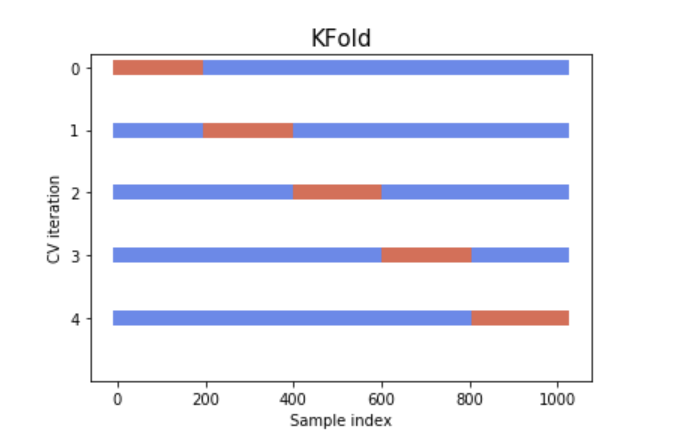

For **time dependent** datasets we have to use cross-val strategy in such way that will prevent the data leakage. 
* TimeSeriesSplit
* TrainTestSplit (shuffle = False)

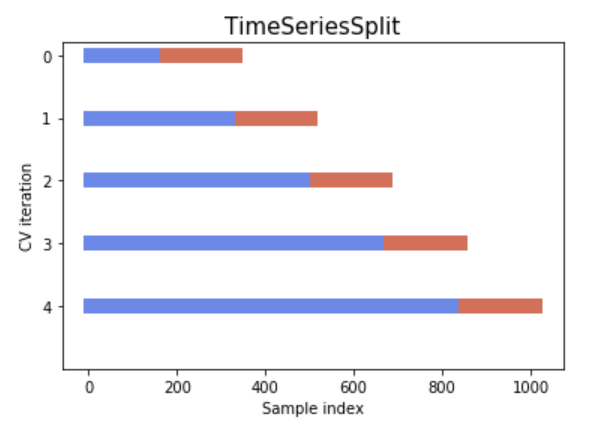

<a id="section-three"></a>
#Application

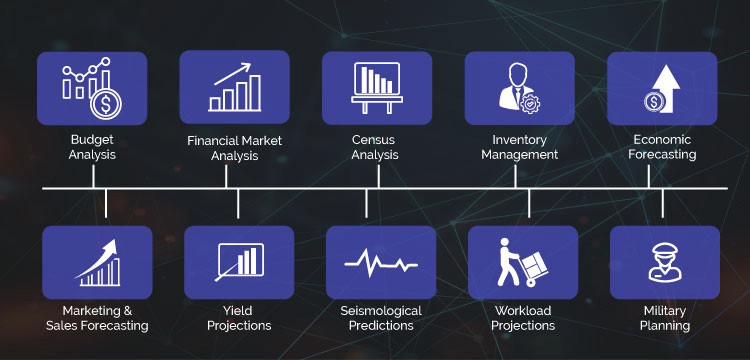

<a id="section-four"></a>
# PROHACK International Hackathon from McKinsey

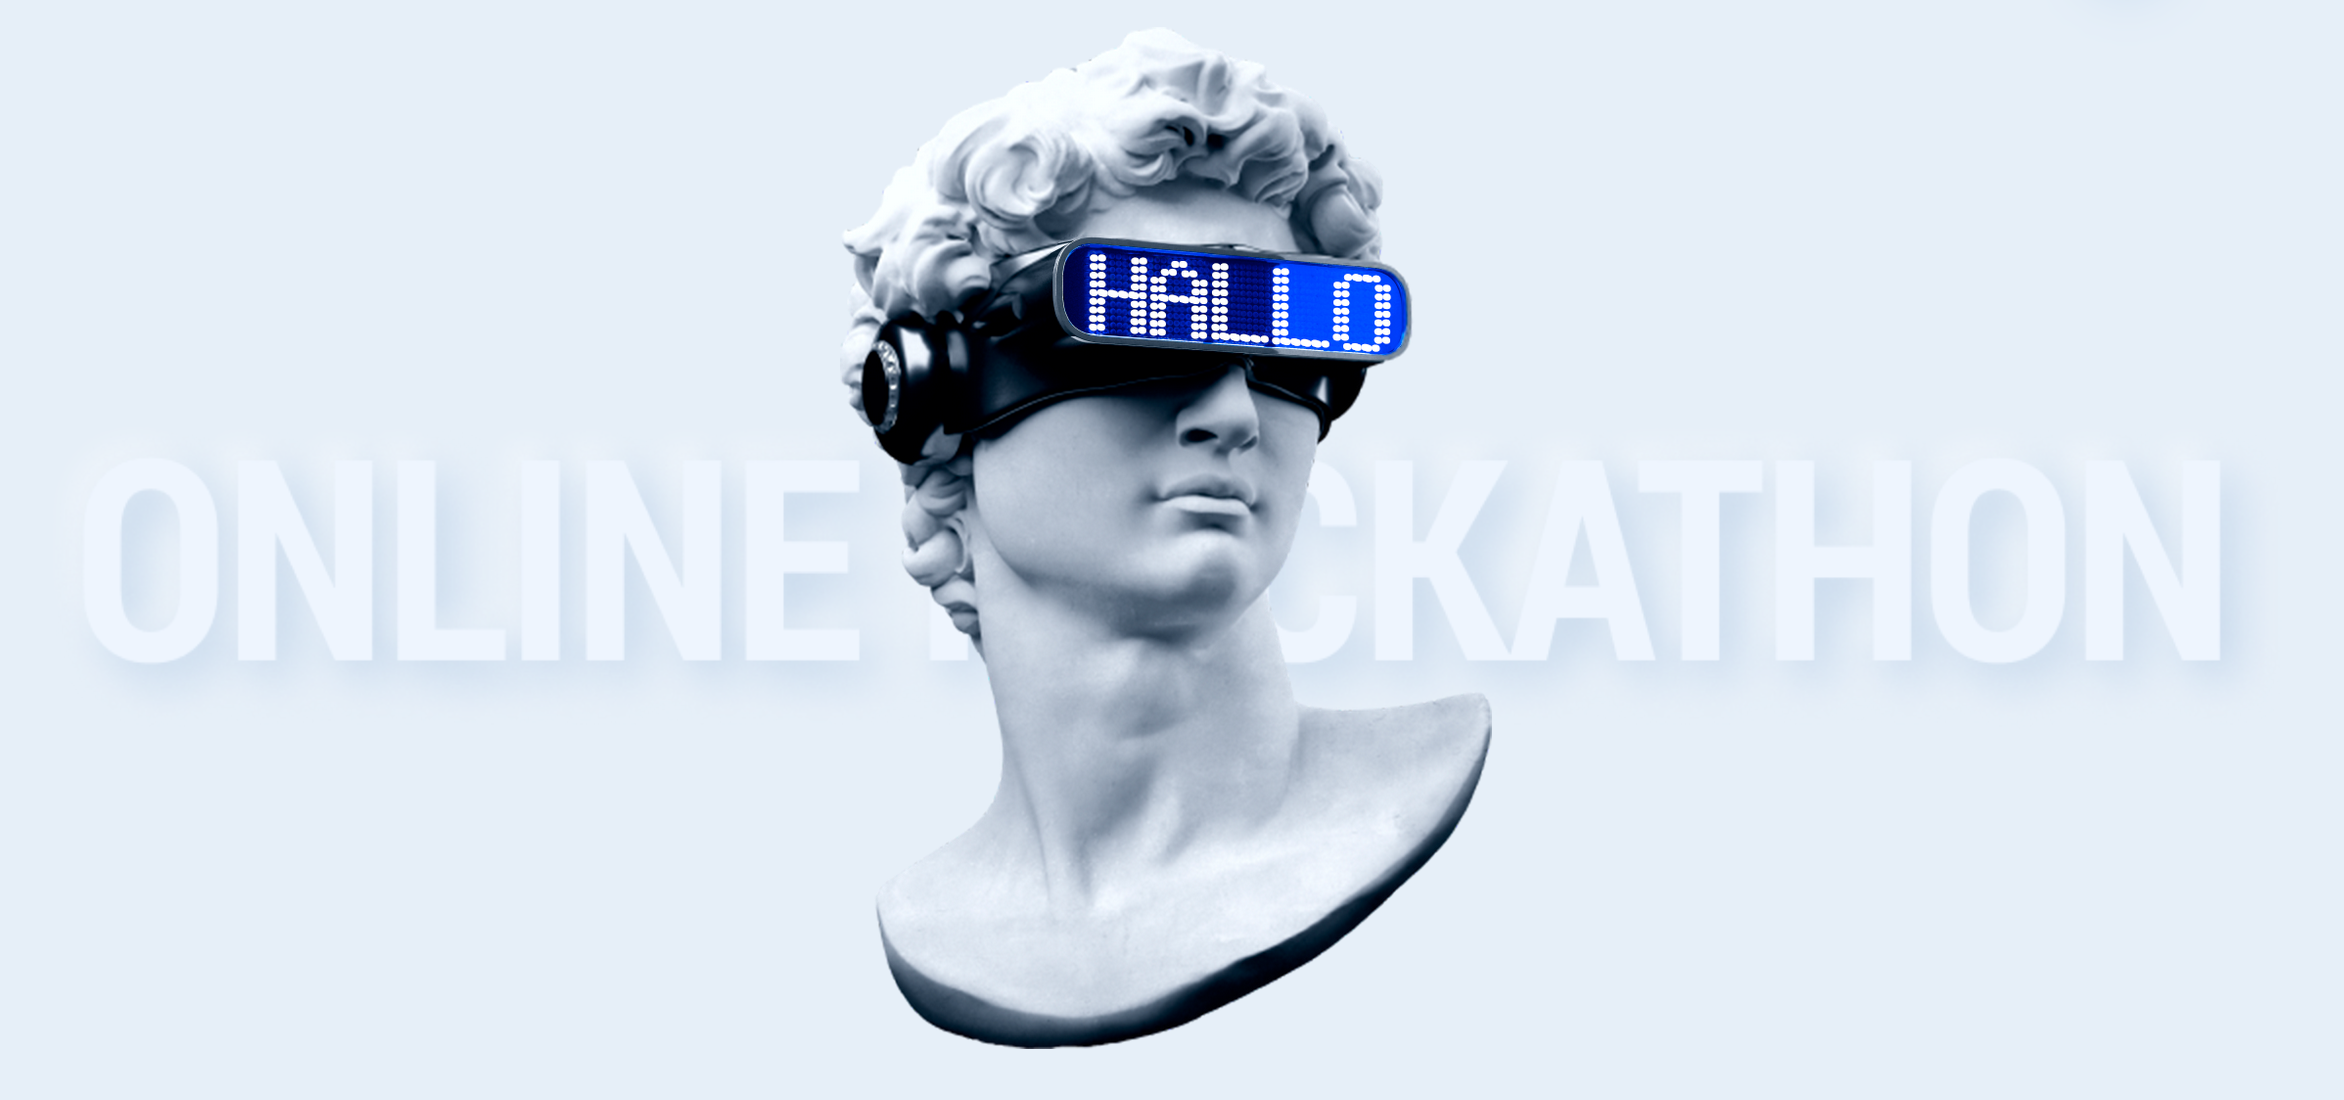

For the last 10 years you’ve been a Chief Data Scientist in one of the best astrophysics research teams in the world. 

Our elders used the composite index to measure our well-being performance, but this knowledge has disappeared in the sands of time.

Use our data and train your model to predict this index with the highest possible level of certainty.

* To achieve the highest possible level of well-being through optimized allocation of additional energy

We have discovered the star of an unusually high energy of 50000 zillion DSML.

We have agreed between ourselves that 

* no one galaxy will consume more than 100 zillion DSML 

and 

* at least 10% of the total energy will be consumed by galaxies in need with existence expectancy index below 0,7.

Think of our galaxies as your “countries” and our population as citizens. We have similar healthcare and wellbeing characteristic as you, Hooomans”


The solutions are evaluated on two criteria: predicted future Index values and allocated energy from a newly discovered star

1) Index predictions are evaluated using RMSE metric

2) Energy allocation is also evaluated using RMSE metric and has a set of known factors that need to be taken into account.

Every galaxy has a certain limited potential for improvement in the index described by the following function: 
Potential for increase in the **Index = -np.log(Index+0.01)+3**
Likely index increase dependent on potential for improvement and on extra energy availability is described by the following function:
Likely increase in the **Index = extra energy * Potential for increase in the Index **2 / 1000**

There are also several constraints:
* in total there are 50000 zillion DSML available for allocation
* no galaxy should be allocated more than 100 zillion DSML or less than 0 zillion DSML
* galaxies with low existence expectancy index below 0.7 should be allocated at least 10% of the total energy available

In [4]:
# read data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv')
sample = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submit.csv')
df = pd.concat([train ,test], ignore_index = True)
SEED = 42

In [5]:
train.shape, test.shape

((3865, 80), (890, 79))

In [6]:
train.head()

galactic year  ...         y
0         990025  ...  0.052590
1         990025  ...  0.059868
2         990025  ...  0.050449
3         990025  ...  0.049394
4         990025  ...  0.154247

[5 rows x 80 columns]

In [7]:
test.head()

galactic year  ... Gender Inequality Index (GII)
0        1007012  ...                           NaN
1        1007012  ...                           NaN
2        1008016  ...                           NaN
3        1007012  ...                           NaN
4        1013042  ...                           NaN

[5 rows x 79 columns]

In [ ]:
# check missing values in train and test data sets
percent_missing_train = train.isnull().sum() * 100 / len(train)
percent_missing_test = test.isnull().sum() * 100 / len(test)

missing_value_train = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing_train}).sort_values('percent_missing', ascending = False).style.background_gradient(cmap='Blues')

missing_value_test = pd.DataFrame({'column_name': test.columns,
                                 'percent_missing': percent_missing_test}).sort_values('percent_missing', ascending = False).style.background_gradient(cmap='Greens')

In [ ]:
missing_value_train

In [ ]:
missing_value_test

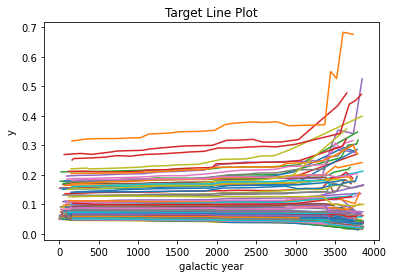

In [ ]:
for i in train.galaxy.unique():
    plt.plot(train[train['galaxy'] == i]['y'], label = i)
    plt.title('Target Line Plot')
    plt.xlabel('galactic year')
    plt.ylabel('y')
#     plt.legend()

In [ ]:
# check correlation between features and target 
cor = pd.DataFrame(train.corr()['y'].abs()).sort_values('y', ascending = False)

a = cor[cor['y'] > 0.1]

a.head()

y
y                                                   1.000000
Gender Inequality Index (GII)                       0.722279
Intergalactic Development Index (IDI), Rank         0.681592
Intergalactic Development Index (IDI), male, Rank   0.680577
Old age dependency ratio (old age (65 and older...  0.679981
Estimated gross galactic income per capita, female  0.667465
Intergalactic Development Index (IDI), female, ...  0.664882
Interstellar Data Net users, total (% of popula...  0.651823
Intergalactic Development Index (IDI)               0.625114
Intergalactic Development Index (IDI), male         0.622699
Intergalactic Development Index (IDI), female       0.614971
Education Index                                     0.613938
Expected years of education (galactic years)        0.584069
Mean years of education (galactic years)            0.583858
Income Index                                        0.579969
Gross galactic product (GGP) per capita             0.576339
Mean years of education, male (galactic years)      0.574598
Expected years of education, male (galactic years)  0.567124
Expected years of education, female (galactic y...  0.557486
existence expectancy at birth                       0.555757
Mean years of education, female (galactic years)    0.554844
existence expectancy index                          0.547397
Life expectancy at birth, male (galactic years)     0.536119
Young age (0-14) dependency ratio (per 100 crea...  0.533741
Domestic credit provided by financial sector (%...  0.533294
Population with at least some secondary educati...  0.531776
Population with at least some secondary educati...  0.531452
Estimated gross galactic income per capita, male    0.517884
Population with at least some secondary educati...  0.517712
Life expectancy at birth, female (galactic years)   0.515975
Gross income per capita                             0.508029
Vulnerable employment (% of total employment)       0.496568
Employment in services (% of total employment)      0.492594
Adolescent birth rate (births per 1,000 female ...  0.491689
Population using at least basic sanitation serv...  0.480033
Population, urban (%)                               0.477494
Employment in agriculture (% of total employment)   0.473959
Mortality rate, male grown up (per 1,000 people)    0.451874
Mortality rate, female grown up (per 1,000 people)  0.441836
Rural population with access to electricity (%)     0.439887
Mortality rate, infant (per 1,000 live births)      0.434110
Population using at least basic drinking-water ...  0.429087
Mortality rate, under-five (per 1,000 live births)  0.390024
Share of seats in senate (% held by female)         0.378091
Current health expenditure (% of GGP)               0.372777
Maternal mortality ratio (deaths per 100,000 li...  0.351186
Gender Development Index (GDI)                      0.339033
Respiratory disease incidence (per 100,000 people)  0.326608
Interstellar phone subscriptions (per 100 people)   0.309870
Exports and imports (% of GGP)                      0.258318

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


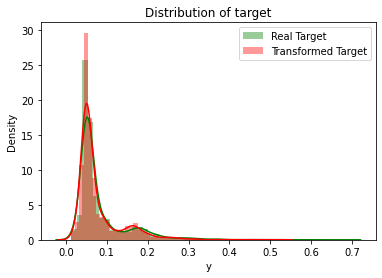

In [ ]:
# distribution of target
sns.distplot(train['y'], label = 'Real Target', color = 'green')
sns.distplot(np.log1p(train['y']), label = 'Transformed Target', color = 'red')
plt.title('Distribution of target')
plt.legend()

In [140]:
# find galaxies that are not in the test dataframe
galaxy_train = (train.galaxy.unique())
galaxy_test = (test.galaxy.unique())
not_matched_galaxies = [list(set(galaxy_train).difference(galaxy_test))]
print('Galaxies that are not in the test set: {}'.format(not_matched_galaxies))

Galaxies that are not in the test set: [['Triangulum Galaxy (M33)', 'Andromeda XXII[57]', 'NGC 5253', 'Tucana Dwarf', 'Andromeda XVIII[60]', 'Hercules Dwarf', 'Andromeda XXIV', 'Andromeda XII', 'Andromeda XIX[60]']]


In [141]:
# drop those galaxies
not_matched_galaxies = ['Andromeda XVIII[60]', 'Andromeda XII', 'Andromeda XIX[60]', 'Hercules Dwarf', 'Triangulum Galaxy (M33)', 'Tucana Dwarf', 'Andromeda XXII[57]', 'NGC 5253', 'Andromeda XXIV']
train = train[~train['galaxy'].isin(not_matched_galaxies)]

In [142]:
# leave columns that are going to be used for modelling
cols = ['galaxy', 'galactic year']

In [143]:
# create train and test
tr = train[cols]
tr['y'] = train.y
ts = test[cols]

<a id="section-five"></a>
# Feature Engineering

In [144]:
# generate some basic statistics 
from scipy import stats 
from scipy.stats import kurtosis 

for c in ['galaxy']:   
    d = {}
    d['last_value_' + c] = tr.groupby([c])['y'].nth(-1)
    d['skewness_' + c] = tr.groupby([c])['y'].skew()
    d['difference_of_the_last_3_values_' + c] = tr.groupby([c])['y'].nth(-1) - tr.groupby([c])['y'].nth(-2) - tr.groupby([c])['y'].nth(-3)
    d['mean_' + c] = tr.groupby([c])['y'].mean()
    d['median_' + c] = tr.groupby([c])['y'].median()
    d['max_' + c] = tr.groupby([c])['y'].max()
    d['min_' + c] = tr.groupby([c])['y'].min()
    d['std_' + c] = tr.groupby([c])['y'].std()
    d['var_' + c] = tr.groupby([c])['y'].var()
    d['mean_abs_chg_' + c] = tr.groupby([c])['y'].apply(lambda x: np.mean(np.abs(np.diff(x))))
    d['99th_percentile_' + c] = tr.groupby([c])['y'].apply(lambda x: np.percentile(x, 99))
    d['95th_percentile_' + c] = tr.groupby([c])['y'].apply(lambda x: np.percentile(x, 95))
    d['max_min_chg_' + c] = tr.groupby([c])['y'].max() - tr.groupby([c])['y'].min()
    for v in d:
        tr[v] = tr[c].map(d[v].to_dict())
        ts[v] = ts[c].map(d[v].to_dict())
        
tr = tr.drop('galaxy', axis = 1)
ts = ts.drop('galaxy', axis = 1)
tr.head()

galactic year         y  ...  95th_percentile_galaxy  max_min_chg_galaxy
0         990025  0.052590  ...                0.052162            0.021230
1         990025  0.059868  ...                0.059928            0.008045
2         990025  0.050449  ...                0.049378            0.032078
3         990025  0.049394  ...                0.048517            0.032709
5         990025  0.052871  ...                0.051994            0.030383

[5 rows x 15 columns]

<a id="section-six"></a>
#Metric

In [149]:
from sklearn.metrics import make_scorer

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

RMSE = make_scorer(rmse, greater_is_better = False)

In [146]:
# log1p of target
X = tr.drop(['y'], axis = 1)
y = np.log1p(tr['y'])
X_test = ts

<a id="section-seven"></a>
# LGBM

In [147]:
#@title
import re
X = X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [150]:
#@title
params_lgb = {
   
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'seed': SEED,
    'learning_rate': 0.1,
    'feature_fraction': 0.95,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'verbose': 3,
    'max_depth': 6,
    'num_leaves': 20
    }


import lightgbm as lgb
scores = []
folds = KFold(n_splits = 3)

predictions = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
   
    print("Fold {}".format(fold_))


    trn_data = lgb.Dataset(X.iloc[trn_idx], label = y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label = y.iloc[val_idx])

    num_round = 1000000
    
    lgbm = lgb.train(params_lgb, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval = 1000, early_stopping_rounds = 100)
    predictions_val = lgbm.predict(X.iloc[val_idx], num_iteration = lgbm.best_iteration)
    
    score = rmse(predictions_val, y.iloc[val_idx])
    scores.append(score)
    
    print("CV score: {:<8.5f}".format(rmse(predictions_val, y.iloc[val_idx])))

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = lgbm.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    predictions += lgbm.predict(X_test, num_iteration = lgbm.best_iteration) / folds.n_splits
    
print('CV mean: {:.6f}, CV std: {:.6f}'.format(np.mean(scores), np.std(scores)))

Fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[21]	training's rmse: 0.0101868	valid_1's rmse: 0.00346548
CV score: 0.00347 
Fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	training's rmse: 0.00524713	valid_1's rmse: 0.00213577
CV score: 0.00214 
Fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[781]	training's rmse: 0.000349724	valid_1's rmse: 0.0189609
CV score: 0.01896 
CV mean: 0.008187, CV std: 0.007637


Text(0.5, 1.0, 'Features importance (averaged/folds)')

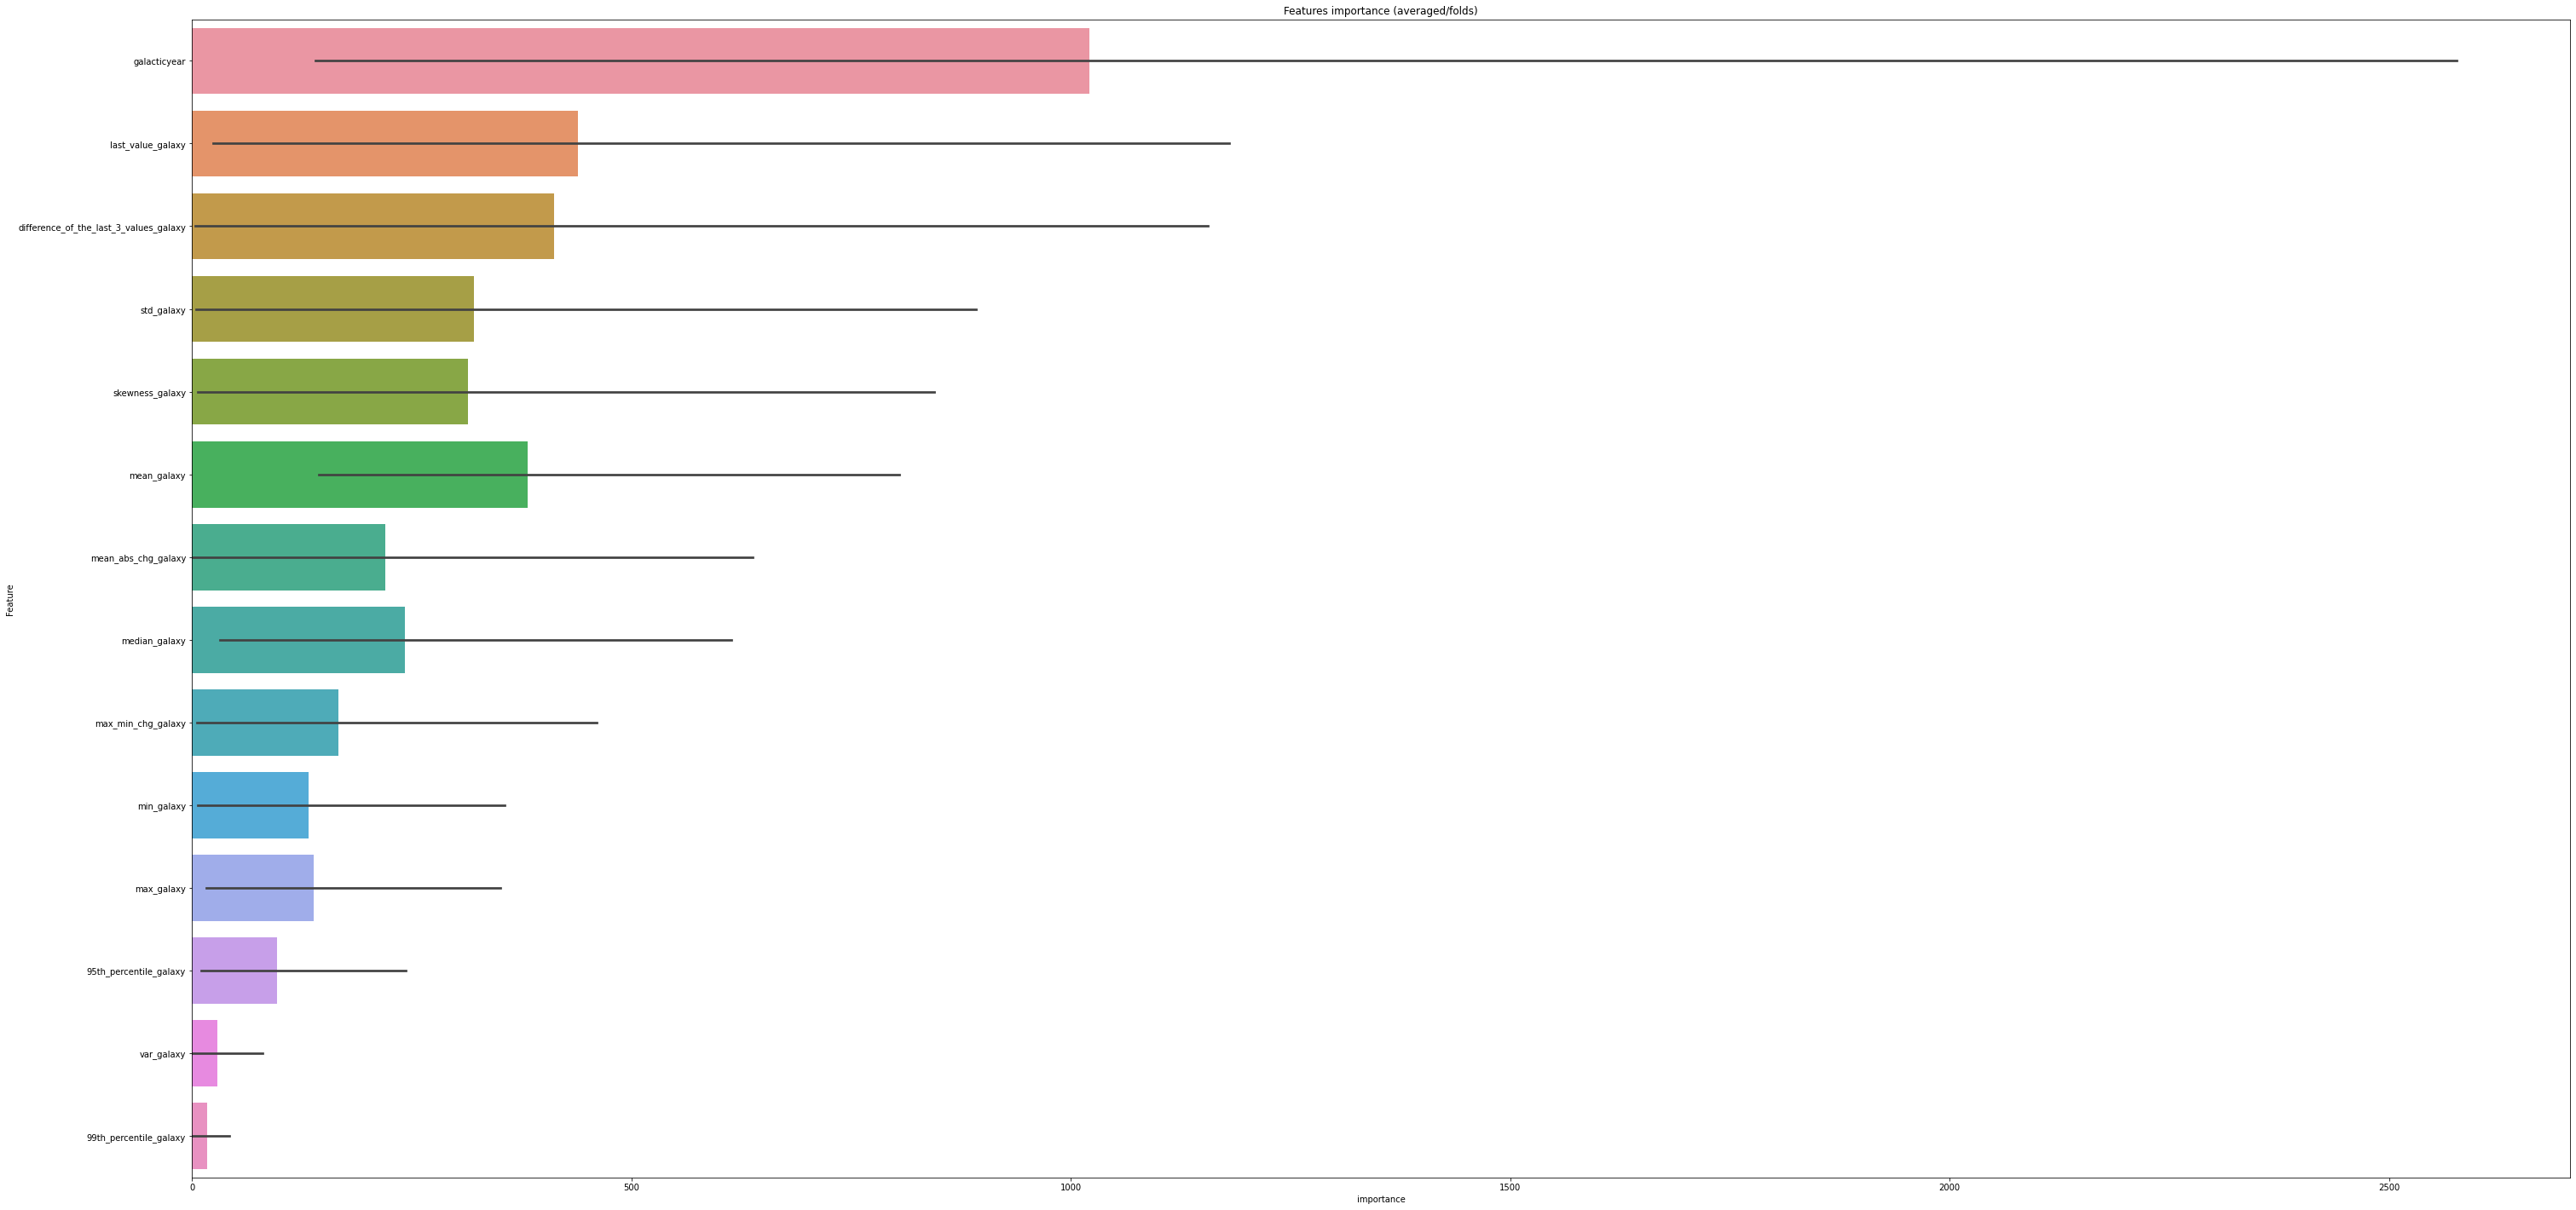

In [151]:
#@title
# feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by = "importance", ascending = False).index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize = (50, 25))
sns.barplot(x = "importance", y = "Feature", data = best_features.sort_values(by = "importance", ascending = False))
plt.title('Features importance (averaged/folds)')

<a id="section-eight"></a>
# Ensemble of 3 models (CatBoost, LGBM, XGBoost)

In [152]:
# split dataset for train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = SEED)

In [154]:
!pip install catboost

     |████████████████████████████████| 66.2MB 45kB/s 


In [156]:
# catboost predictions
import catboost
catboost_parameters = {
          'eval_metric' : "RMSE",
          'learning_rate' : 0.1,
          'iterations' : 100,
          'l2_leaf_reg' : 5,
          'random_seed' : SEED,
          'depth' : 8
#           'early_stopping_rounds' : 100,
#           'use_best_model' : True
         }
cb = catboost.CatBoostRegressor(**catboost_parameters)
cb.fit(X_train, y_train, eval_set = (X_valid, y_valid))
pred_catboost = cb.predict(X_valid)

0:	learn: 0.0498926	test: 0.0496319	best: 0.0496319 (0)	total: 56.2ms	remaining: 5.56s
1:	learn: 0.0456577	test: 0.0451279	best: 0.0451279 (1)	total: 63.2ms	remaining: 3.1s
2:	learn: 0.0418536	test: 0.0413296	best: 0.0413296 (2)	total: 70.3ms	remaining: 2.27s
3:	learn: 0.0384425	test: 0.0380061	best: 0.0380061 (3)	total: 77.4ms	remaining: 1.86s
4:	learn: 0.0353959	test: 0.0348234	best: 0.0348234 (4)	total: 84.4ms	remaining: 1.6s
5:	learn: 0.0324770	test: 0.0320021	best: 0.0320021 (5)	total: 91.2ms	remaining: 1.43s
6:	learn: 0.0298415	test: 0.0292681	best: 0.0292681 (6)	total: 98.1ms	remaining: 1.3s
7:	learn: 0.0275610	test: 0.0270200	best: 0.0270200 (7)	total: 105ms	remaining: 1.21s
8:	learn: 0.0254066	test: 0.0248051	best: 0.0248051 (8)	total: 112ms	remaining: 1.13s
9:	learn: 0.0235169	test: 0.0228656	best: 0.0228656 (9)	total: 119ms	remaining: 1.07s
10:	learn: 0.0217599	test: 0.0210319	best: 0.0210319 (10)	total: 126ms	remaining: 1.02s
11:	learn: 0.0201528	test: 0.0193714	best: 0.019

In [157]:
# lgbm predictions
lgbm_parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.2,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    "max_depth": 5,
    "num_leaves": 20,  
    "seed": SEED,
    "early_stopping_rounds": 100,
    'num_round' : 100
    }
lgbm = LGBMRegressor(**lgbm_parameters)
lgbm.fit(X_train, y_train, eval_set = (X_valid, y_valid))
pred_lightgbm = lgbm.predict(X_valid)

[1]	valid_0's rmse: 0.0439743
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.035574
[3]	valid_0's rmse: 0.0290156
[4]	valid_0's rmse: 0.0236092
[5]	valid_0's rmse: 0.0193127
[6]	valid_0's rmse: 0.0160566
[7]	valid_0's rmse: 0.0136465
[8]	valid_0's rmse: 0.0118138
[9]	valid_0's rmse: 0.00989977
[10]	valid_0's rmse: 0.00875439
[11]	valid_0's rmse: 0.00782925
[12]	valid_0's rmse: 0.00713181
[13]	valid_0's rmse: 0.0064282
[14]	valid_0's rmse: 0.00592434
[15]	valid_0's rmse: 0.00559354
[16]	valid_0's rmse: 0.00547207
[17]	valid_0's rmse: 0.00520236
[18]	valid_0's rmse: 0.0051416
[19]	valid_0's rmse: 0.00511104
[20]	valid_0's rmse: 0.0048291
[21]	valid_0's rmse: 0.00485818
[22]	valid_0's rmse: 0.00484412
[23]	valid_0's rmse: 0.00484745
[24]	valid_0's rmse: 0.00484551
[25]	valid_0's rmse: 0.00472925
[26]	valid_0's rmse: 0.00470893
[27]	valid_0's rmse: 0.00473077
[28]	valid_0's rmse: 0.00475529
[29]	valid_0's rmse: 0.00483646
[30]	valid_0's rmse: 0.0046551

In [158]:
# xgb predictions
import xgboost as xgb
xgboost_parameters = {
          'colsample_bytree' : 0.8,
          'gamma' : 0, 
          'booster' :  "gbtree",
          'eval_metric' : 'rmse',
          'eta' : 0.01,
          'max_depth' : 10,
          'min_child_weight' : 1.5,
          'n_estimators' : 100,                                                                    
          'subsample' : 0.95,
          'seed' : SEED
         }

xb = xgb.XGBRegressor(**xgboost_parameters)
xb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 100)
pred_xgboost = xb.predict(X_valid)

[13:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.382313
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:0.344172
[2]	validation_0-rmse:0.309824
[3]	validation_0-rmse:0.278912
[4]	validation_0-rmse:0.251025
[5]	validation_0-rmse:0.225903
[6]	validation_0-rmse:0.203413
[7]	validation_0-rmse:0.183094
[8]	validation_0-rmse:0.164887
[9]	validation_0-rmse:0.148442
[10]	validation_0-rmse:0.133697
[11]	validation_0-rmse:0.120448
[12]	validation_0-rmse:0.108483
[13]	validation_0-rmse:0.097709
[14]	validation_0-rmse:0.087993
[15]	validation_0-rmse:0.079286
[16]	validation_0-rmse:0.071464
[17]	validation_0-rmse:0.064389
[18]	validation_0-rmse:0.058013
[19]	validation_0-rmse:0.052295
[20]	validation_0-rmse:0.047153
[21]	validation_0-rmse:0.042499
[22]	validation_0-rmse:0.038319
[23]	validation_0-rmse:0.034556
[24]	validation_0-rmse:0.031199
[25]	validation_0

In [159]:
print('-----------------------------------')
print('RMSE for three models')
print('-----------------------------------')
print('RMSE of CatBoost: {:.6f}'.format(rmse(y_valid, pred_catboost)))
print('RMSE of LGBM: {:.6f}'.format(rmse(y_valid, pred_lightgbm)))
print('RMSE of XGB: {:.6f}'.format(rmse(y_valid, pred_xgboost)))

-----------------------------------
RMSE for three models
-----------------------------------
RMSE of CatBoost: 0.003239
RMSE of LGBM: 0.003275
RMSE of XGB: 0.002745


In [160]:
predictions = []
for i in [pred_catboost, pred_lightgbm, pred_xgboost]:
    predictions.append(i)

In [161]:
# define objective function (rmse) to minimize and find weights for ensemble
def rmse_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight * prediction
    return rmse(y_valid, final_prediction)

In [162]:
from scipy.optimize import minimize

x0 = [0.1] * len(predictions)

cons = ({'type':'eq','fun': lambda w: 1 - sum(w)})

bounds = [(0,1)] * len(predictions)

res = minimize(rmse_func, x0, method = 'SLSQP', bounds = bounds, constraints = cons)

In [163]:
print('Ensamble Score: {best_score}'.format(best_score = res['fun']))
print('Best Weights: {weights}'.format(weights = res['x']))

Ensamble Score: 0.0026091282908038303
Best Weights: [0.33355591 0.33339172 0.33305238]


In [164]:
res['x'][0]

0.33355590628598814

In [169]:
# lgbm predictions
hyperparams_lgb = {
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.1,
    'bagging_freq': 5,
    'max_depth': 6,
    'num_leaves': 20,  
    'seed': 42,
    'num_round' : 100
    }
lgbm = LGBMRegressor(**hyperparams_lgb)
lgbm.fit(X, y)
predictions_lightgbm = np.expm1(lgbm.predict(X_test))

In [170]:
# xgb predictions
import xgboost as xgb
xgboost_parameters = {
          'colsample_bytree' : 0.8,
          'gamma' : 0, 
          'booster' :  "gbtree",
          'eval_metric' : 'rmse',
          'eta' : 0.01,
          'max_depth' : 10,
          'min_child_weight' : 1.5,
          'n_estimators' : 100,                                                                    
          'subsample' : 0.95,
          'seed' : SEED
         }

xb = xgb.XGBRegressor(**xgboost_parameters)
xb.fit(X, y)
predictions_xgb = np.expm1(xb.predict(X_test))

[13:34:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [168]:
# cstboost predictions
hyperparams_catboost = {
          'eval_metric' : "RMSE",
          'learning_rate' : 0.1,
          'random_seed' : 42,
          'depth' : 7,
          'iterations' : 100
         }

cb = catboost.CatBoostRegressor(**hyperparams_catboost)

cb.fit(X, y)
predictions_ctb = np.expm1(cb.predict(X_test))

0:	learn: 0.0497656	total: 5.58ms	remaining: 553ms
1:	learn: 0.0453996	total: 9.94ms	remaining: 487ms
2:	learn: 0.0414885	total: 13.8ms	remaining: 445ms
3:	learn: 0.0379167	total: 17.5ms	remaining: 421ms
4:	learn: 0.0347095	total: 21.4ms	remaining: 406ms
5:	learn: 0.0318503	total: 25.3ms	remaining: 396ms
6:	learn: 0.0291789	total: 29.2ms	remaining: 388ms
7:	learn: 0.0267884	total: 33ms	remaining: 379ms
8:	learn: 0.0245909	total: 37.1ms	remaining: 375ms
9:	learn: 0.0226293	total: 41.1ms	remaining: 370ms
10:	learn: 0.0208287	total: 45.2ms	remaining: 365ms
11:	learn: 0.0191991	total: 49.3ms	remaining: 362ms
12:	learn: 0.0177502	total: 53.3ms	remaining: 356ms
13:	learn: 0.0163959	total: 57.1ms	remaining: 350ms
14:	learn: 0.0152470	total: 61.5ms	remaining: 348ms
15:	learn: 0.0141974	total: 65.4ms	remaining: 344ms
16:	learn: 0.0132219	total: 69.3ms	remaining: 338ms
17:	learn: 0.0123577	total: 73.3ms	remaining: 334ms
18:	learn: 0.0115162	total: 77.3ms	remaining: 329ms
19:	learn: 0.0107859	tot

In [172]:
# average of 3 models as their weights almost the same 
predictions = res['x'][0] * predictions_ctb + res['x'][1] * predictions_lightgbm + res['x'][2] * predictions_xgb
predictions

array([0.04372974, 0.04069947, 0.04072095, 0.04017712, 0.02112188,
       0.03360868, 0.02974286, 0.0434464 , 0.04169516, 0.04233975,
       0.03887815, 0.019363  , 0.04376212, 0.04225952, 0.02710578,
       0.0400632 , 0.02577832, 0.03002944, 0.04042139, 0.03911613,
       0.03763854, 0.02081191, 0.03871359, 0.03376128, 0.04307863,
       0.02339191, 0.02862017, 0.03873424, 0.04249375, 0.03386266,
       0.0413907 , 0.04027752, 0.04242569, 0.06003636, 0.01978036,
       0.03910941, 0.04186934, 0.03924699, 0.0190346 , 0.03049194,
       0.04060802, 0.02251446, 0.03920306, 0.04169147, 0.06021446,
       0.02915743, 0.0401622 , 0.02805   , 0.03989718, 0.01870302,
       0.04060777, 0.04171952, 0.0203131 , 0.03990836, 0.02452376,
       0.04150216, 0.01949495, 0.01882796, 0.02465047, 0.04136818,
       0.03132276, 0.04584573, 0.02912758, 0.04109762, 0.03393814,
       0.03715216, 0.04032457, 0.01896458, 0.04428173, 0.0472386 ,
       0.04694188, 0.04011966, 0.03309432, 0.03046836, 0.04305

<a id="section-nine"></a>
# Optimization with SciPy

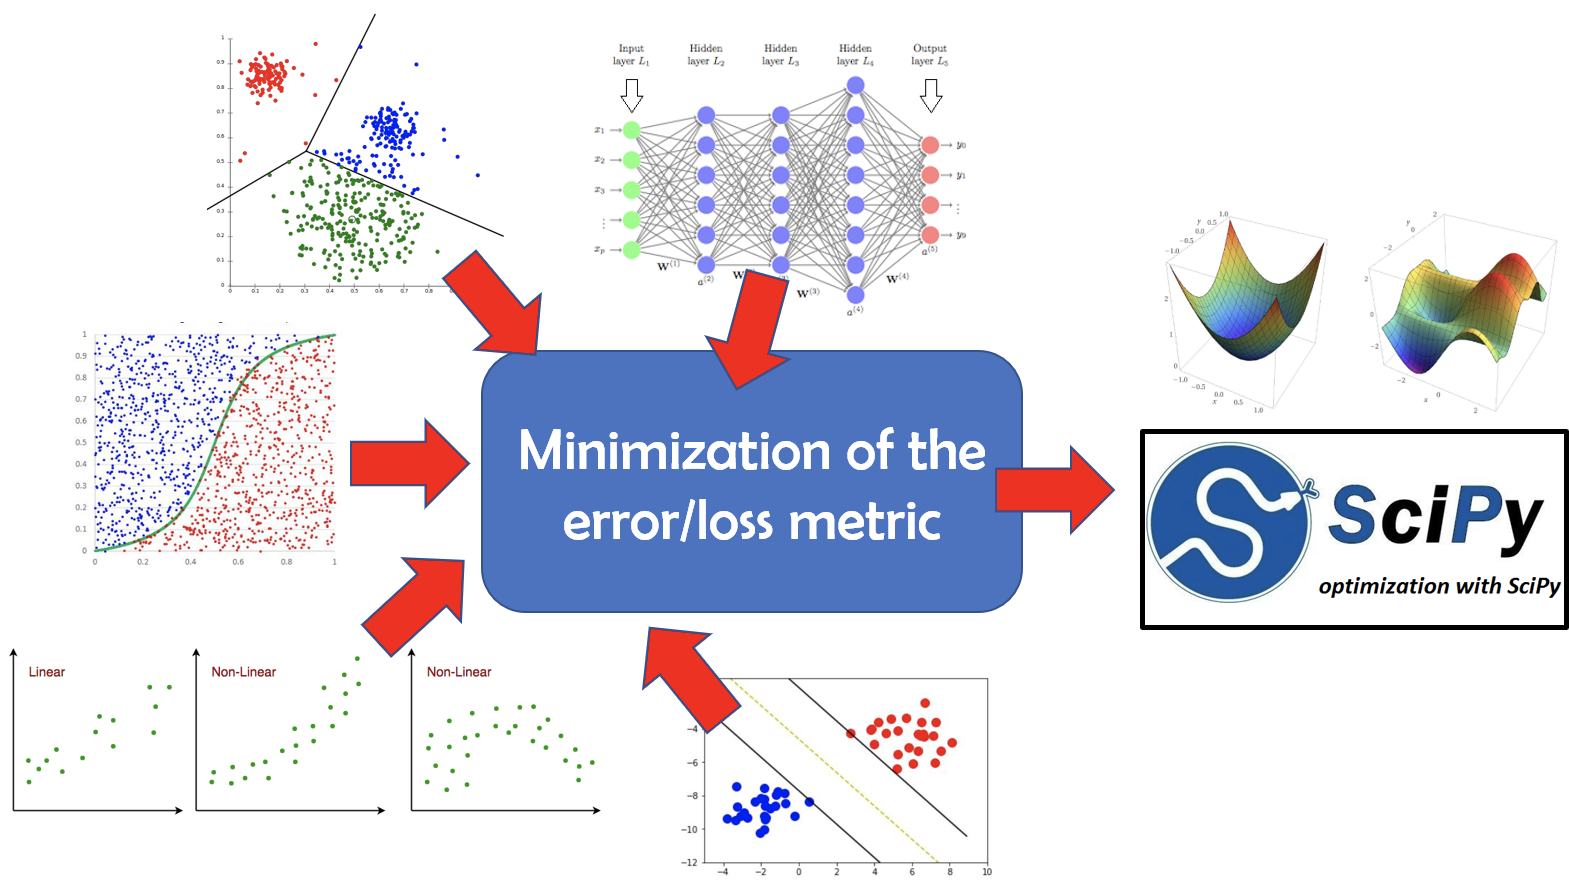

In [173]:
from scipy.optimize import minimize, LinearConstraint

In [174]:
sample['pred'] = predictions

In [187]:
'''Define all functions required for optimization'''

def increase(target):
    '''Define the function for potential increase as given in the task'''
    return - np.log(target + 0.01) + 3

def objective(extra_energy, increase):
    '''Define the objective function (its sum) that needs to be maximized, multiply by negative 1 as scipy minimizes'''
    return -1 * (extra_energy * increase ** 2 / 1000).sum()

def constraint_1(extra_energy):
    '''The first constraint is that sum of all allocated energy is less or equal to 50,000'''
    return -1 * np.sum(extra_energy) + 50000

def constraint_2(extra_energy):
    '''The second constraint is that sum of allocated energy for galaxies with existence expectancy index < 0.7 (or first 66 values in test set) is at least 5,000'''
    return np.sum(extra_energy[:66]) - 5000

print('All functions are set.')

All functions are set.


In [204]:
sample['increase'] =  increase(sample['pred'])
sample.head(20)

index      pred  opt_pred  increase
0       0  0.043730       100  5.923789
1       1  0.040699       100  5.981840
2       2  0.040721       100  5.981416
3       3  0.040177       100  5.992196
4       4  0.021122       100  6.469844
5       5  0.033609       100  6.132499
6       6  0.029743       100  6.225325
7       7  0.043446       100  5.929076
8       8  0.041695       100  5.962391
9       9  0.042340       100  5.949999
10     10  0.038878       100  6.018425
11     11  0.019363       100  6.528020
12     12  0.043762       100  5.923186
13     13  0.042260       100  5.951533
14     14  0.027106       100  6.293983
15     15  0.040063       100  5.994469
16     16  0.025778       100  6.330413
17     17  0.030029       100  6.218140
18     18  0.040421       100  5.987340
19     19  0.039116       100  6.013568

In [179]:
potential_increase(sample['pred'])

0      5.923789
1      5.981840
2      5.981416
3      5.992196
4      6.469844
         ...   
885    6.413295
886    6.167059
887    5.578815
888    5.698944
889    6.366108
Name: pred, Length: 890, dtype: float64

In [195]:
import time

t = Timer()
t.start()

# generate initial values for optimization
x0 = [100 for i in range(len(test))]

# define the bounds i.e. each value of allocated energy should be in range 0 <= extra_energy <= 100
b = (0, 100)
bnds = tuple([b for i in range(len(test))])

# both constraints are inequality constraints
cons = ({'type' : 'ineq', 'fun' : constraint_1},
        {'type' : 'ineq', 'fun' : constraint_2})

solution = minimize(objective, x0, args = (increase(sample['pred'])),
                   method = 'SLSQP',
                   bounds = bnds,
                   constraints = cons,
                   options = {'maxiter' : 10,
                              'disp' : True
                              }
                   )

x = solution.x

t.stop()

Iteration limit exceeded    (Exit mode 9)
            Current function value: -1722.3453706696453
            Iterations: 11
            Function evaluations: 9812
            Gradient evaluations: 11
Elapsed time: 20.0014 seconds


In [196]:
x.sum()

49999.999999999935

In [197]:
x[:66].sum()

5932.049370414915

In [198]:
x

array([ 83.98629381,  85.88914804,  85.88091646,  86.22017669,
       100.        ,  90.84634618,  93.9567252 ,  84.19138008,
        85.26722318,  84.85353617,  87.08788075, 100.        ,
        83.98573332,  84.8960621 ,  96.274009  ,  86.30161511,
        97.51667018,  93.70850646,  86.05471714,  86.92241918,
        87.91550512, 100.        ,  87.17205544,  90.72919588,
        84.39951913,  99.91527138,  94.90967871,  87.1707367 ,
        84.77068021,  90.64652198,  85.43412452,  86.17091639,
        84.80538986,  75.66880992, 100.        ,  86.92241918,
        85.14433359,  86.83960926, 100.        ,  93.32906105,
        85.93069801, 100.        ,  86.8410268 ,  85.26722318,
        75.61902837,  94.45329869,  86.22053832,  95.40658331,
        86.38621226, 100.        ,  85.9306675 ,  85.22761199,
       100.        ,  86.38603712,  98.75672386,  85.38463724,
       100.        , 100.        ,  98.63243226,  85.46739441,
        92.63269387,  82.78450832,  94.48766131,  85.63

In [ ]:
sample['opt_pred'] = x
sample.to_csv('Prohack_final_submission.csv', index = False)

In [ ]:
sample

<a id="section-ten"></a>
# The End

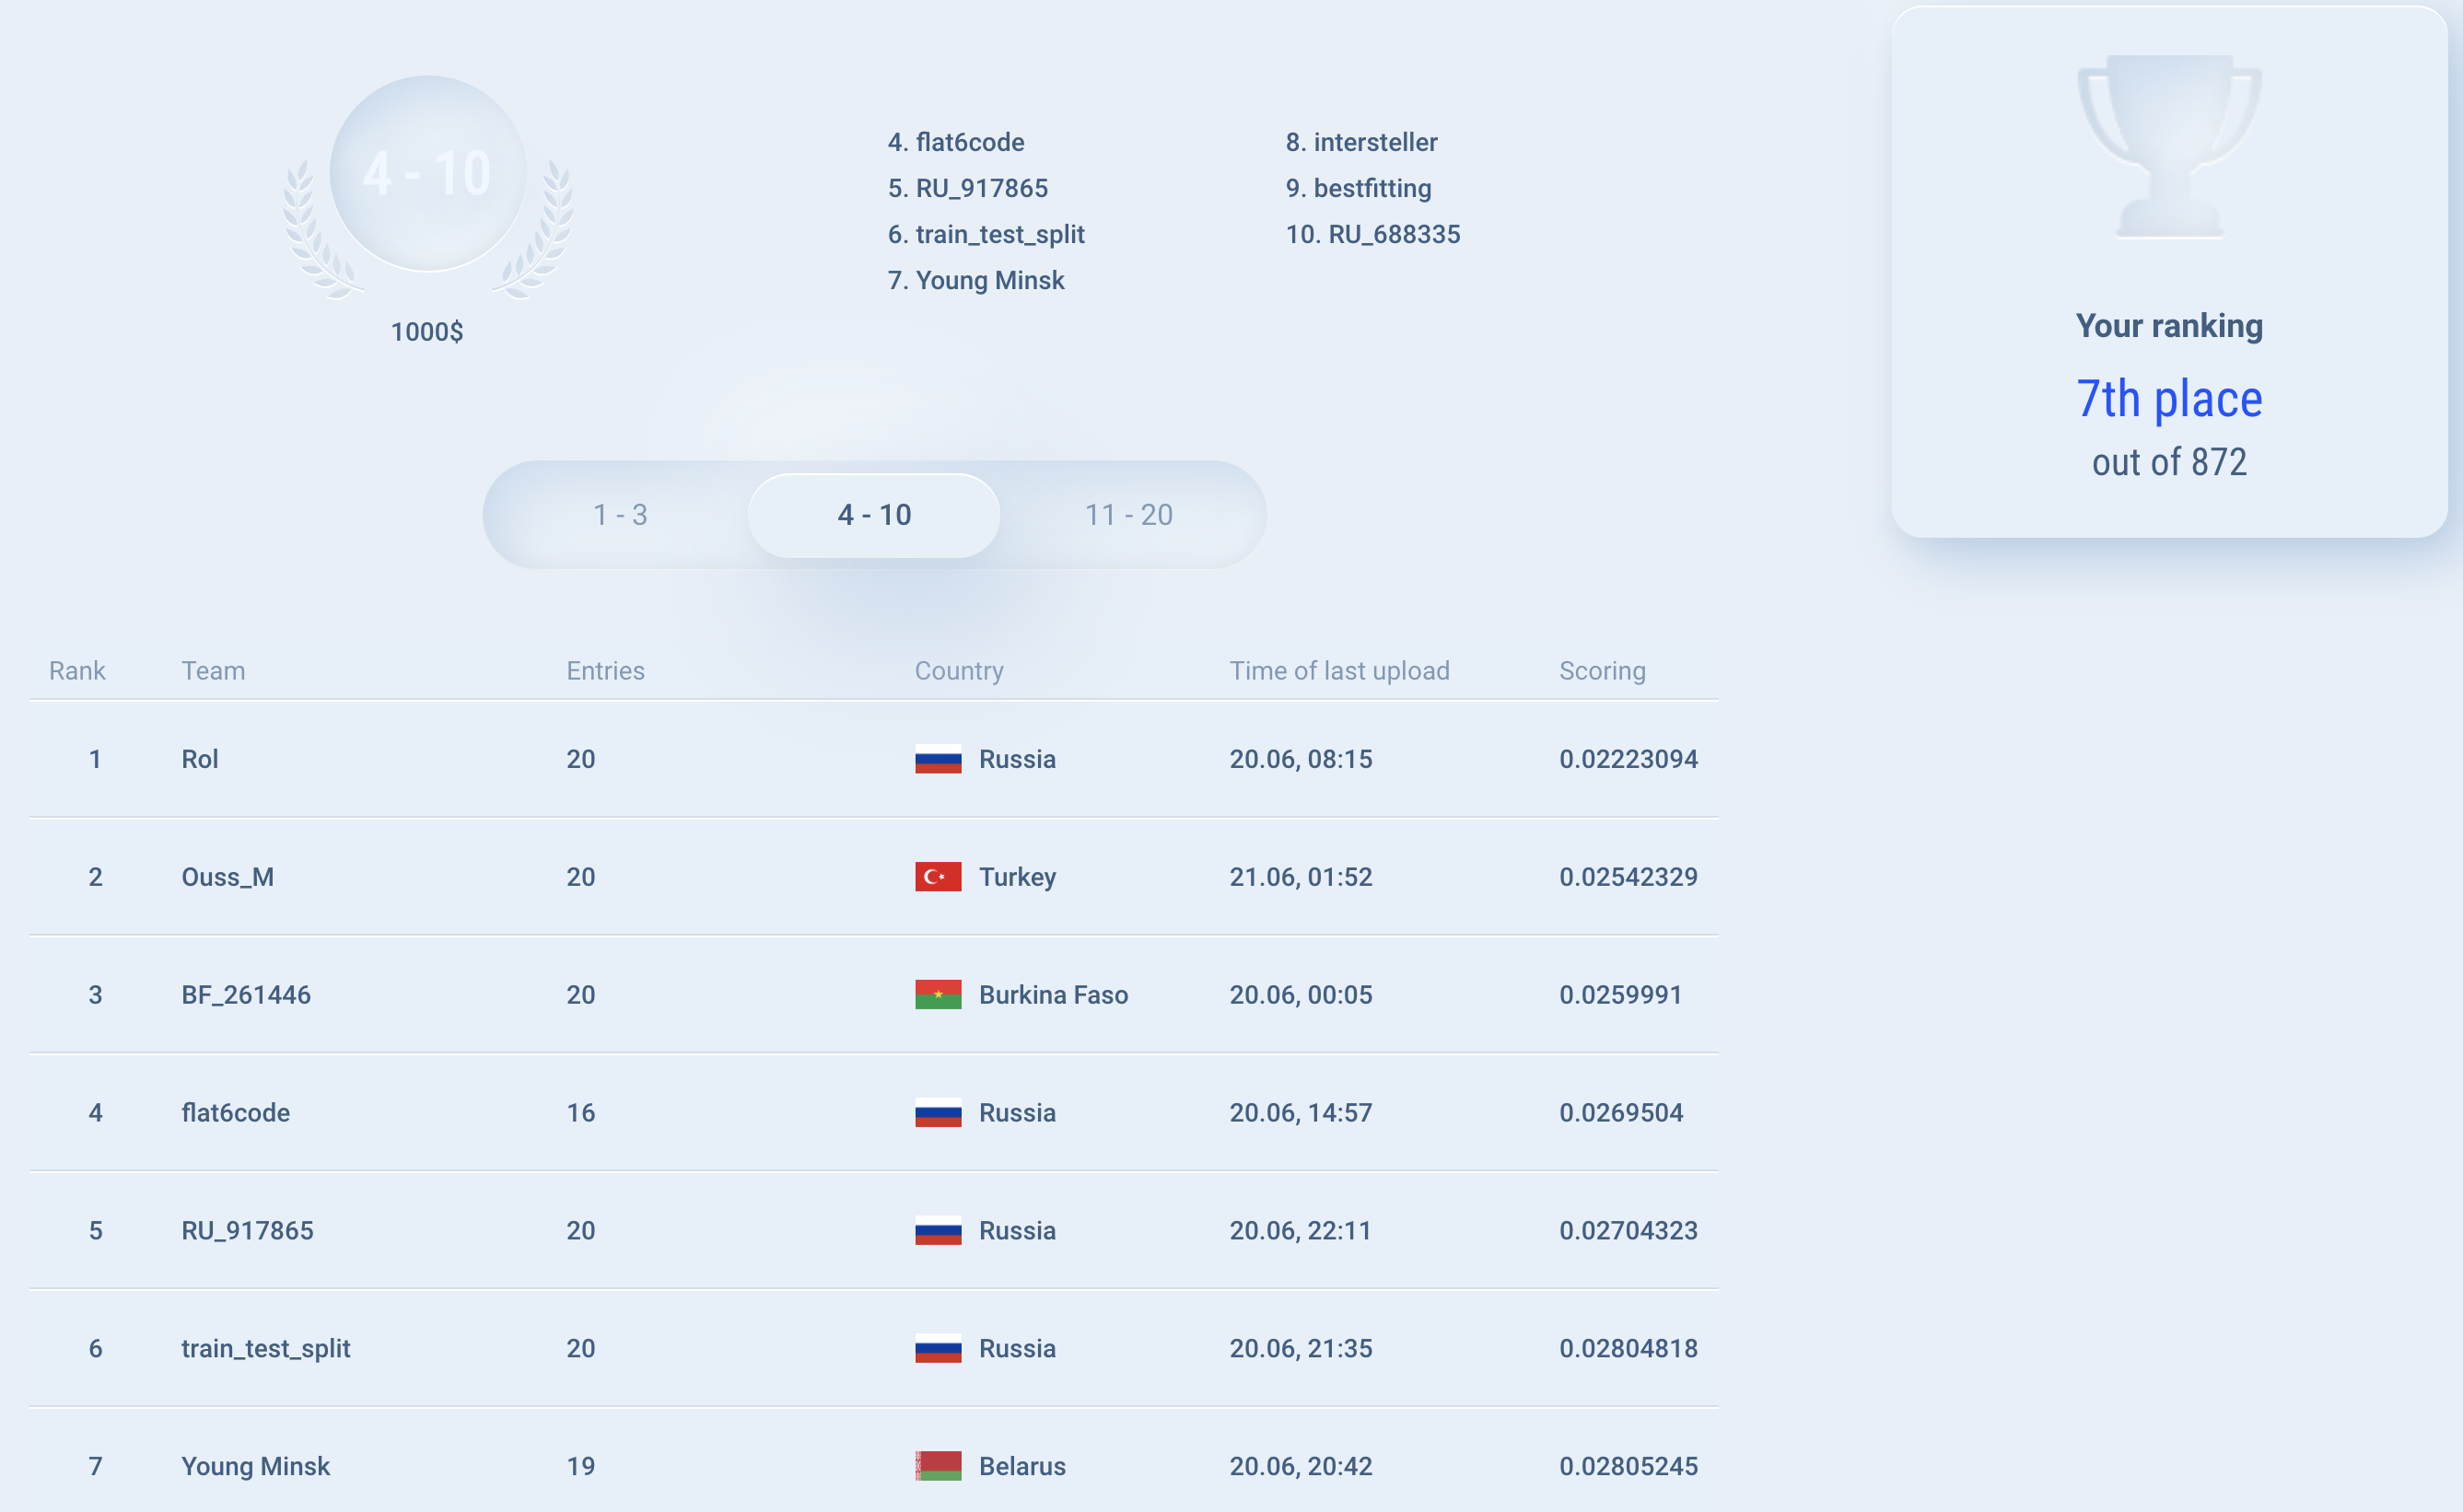

<a id="section-eleven"></a>
#Neptune AI for Version Control and Experiments

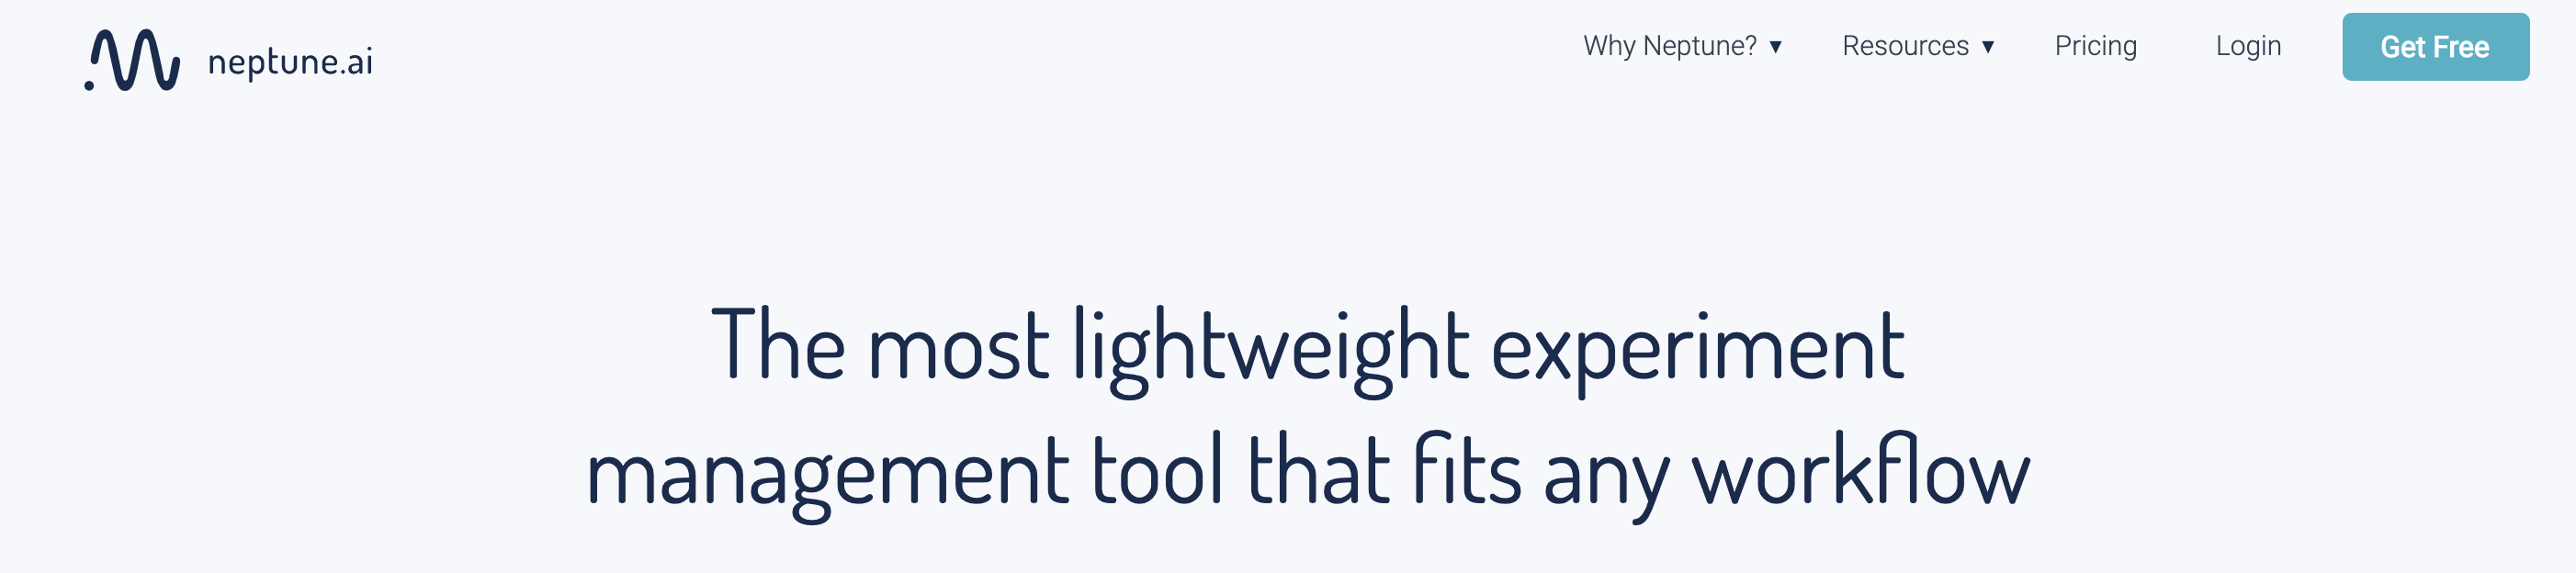

In [ ]:
#@title
!pip install neptune-client

     |████████████████████████████████| 92kB 2.4MB/s 
     |████████████████████████████████| 829kB 8.8MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 204kB 14.7MB/s 
     |████████████████████████████████| 163kB 17.0MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 133kB 16.3MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.125-py2.py3-none-any.whl size=151812 sha256=336f3cccf8e02d37069b874fcecc425d482e855c75040c81dfc8bdd8637ba9f8
  Stored in directory: /root/.cache/pip/wheels/fc/f1/47/d7b65b61a1d16995ca4e474f5dcc215459770e9438842f6de8
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=6329fa31357332b520dd2f3cb6d1520858a6cfed9baf6dd923549fb45c59dad4
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for s

In [ ]:
NEPTUNE_API_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNDVkMGFjZGQtM2Y1NC00OTQ4LTk0YTMtNDU4MTU4YTI1MWU2In0="

In [ ]:
import neptune

neptune.init(api_token = NEPTUNE_API_TOKEN, 
             project_qualified_name='datasobig1994/experiment-1')

Project(datasobig1994/experiment-1)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X, y = make_classification(n_samples = 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

params = {'n_estimators':10,
          'criterion': 'gini',
          'max_depth': 2,
          'min_samples_split': 100}

neptune.create_experiment(params = params)

clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)

https://ui.neptune.ai/datasobig1994/experiment-1/e/EX-2


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import roc_auc_score

y_test_pred = clf.predict_proba(X_test)
score = roc_auc_score(y_test, y_test_pred[:, 1])

neptune.send_metric('roc_auc_test', score)

In [ ]:
for epoch in range(10):
  epoch_score = roc_auc_score(y_test, y_test_pred[:, 1])
  neptune.send_metric('roc_auc_test', epoch_score)

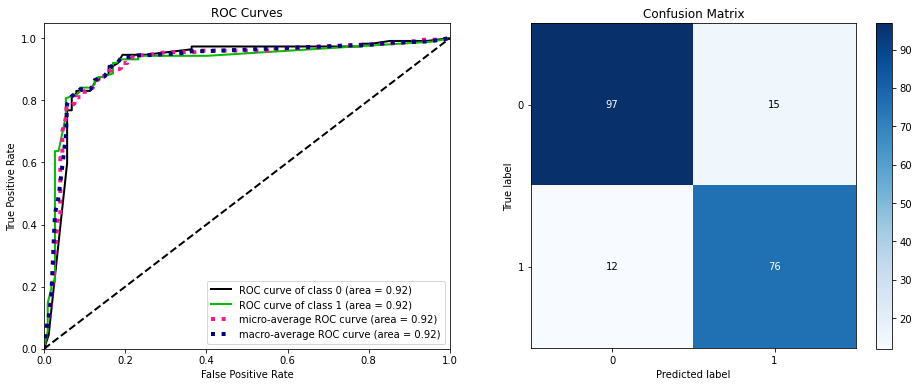

In [ ]:
!pip install scikit-plot
import scikitplot
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))
plot_roc(y_test, y_test_pred, ax = ax1)
plot_confusion_matrix(y_test, y_test_pred[:, 1] > 0.5, ax = ax2)

fig.savefig('model_diagnostics.png') 
neptune.send_image('model_diagnostics', 'model_diagnostics.png')

<Figure size 1152x432 with 0 Axes>

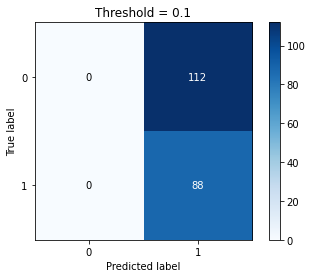

<Figure size 1152x432 with 0 Axes>

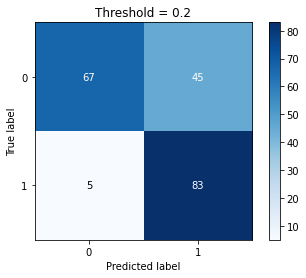

<Figure size 1152x432 with 0 Axes>

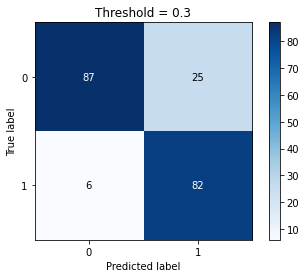

<Figure size 1152x432 with 0 Axes>

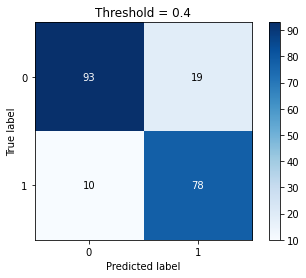

<Figure size 1152x432 with 0 Axes>

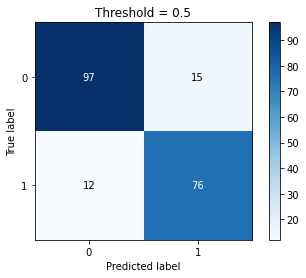

<Figure size 1152x432 with 0 Axes>

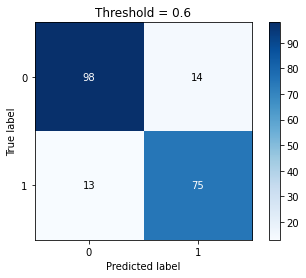

<Figure size 1152x432 with 0 Axes>

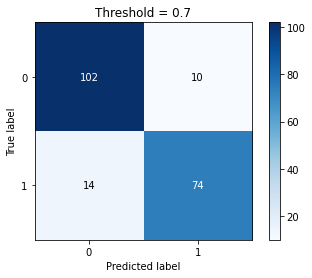

<Figure size 1152x432 with 0 Axes>

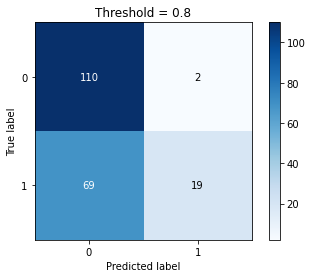

<Figure size 1152x432 with 0 Axes>

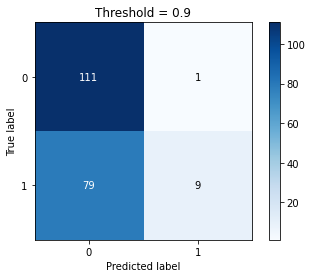

In [ ]:
for thres in [i/10 for i in range(1, 10, 1)]:
    fig = plt.figure(figsize = (16,6))
    plot_confusion_matrix(y_test, y_test_pred[:, 1] > thres)
    plt.title('Threshold = {}'.format(thres))
    plt.savefig('confusion_matrix.png') 
    neptune.send_image('confusion_matrix', 'confusion_matrix.png', name='threshold {}'.format(thres))

In [ ]:
from sklearn.externals import joblib

joblib.dump(clf, 'rf_model.pkl')
neptune.send_artifact('rf_model.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
neptune.stop()